# Masked Autoencoder (MAE) Demo

This notebook implements a step-by-step Masked Autoencoder (MAE) pipeline on the Imagenette dataset using PyTorch. It demonstrates the core MAE concept: randomly masking image patches, encoding visible patches with a Vision Transformer, and reconstructing the masked regions using a decoder with learnable mask tokens.

## 1. Setup and Data Loading

### Import Libraries
Import necessary libraries for image processing, deep learning, and visualization.

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    Compose,
    ToTensor,
    ToPILImage,
)
import tensorflow_datasets as tfds
from torch.utils.data import IterableDataset, DataLoader
import matplotlib.pyplot as plt

### Configuration
Define image size and patch size for processing.

In [2]:
img_size = 224
patch_size = 32

### Load Dataset
Load the Imagenette dataset (training and validation splits) using TensorFlow Datasets. Each example is returned as a dictionary with image and label, and metadata is captured in the `info` object.

In [3]:
ds_train, info = tfds.load(
    "imagenette/320px", split="train", as_supervised=False, with_info=True
)
ds_val = tfds.load("imagenette/320px", split="validation", as_supervised=False)

2026-01-08 11:08:58.677211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 11:08:58.685951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767888538.696760   11753 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767888538.699866   11753 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767888538.708477   11753 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 2. Data Preprocessing

### Image Transformations
Define image augmentation pipeline including random resized crop, horizontal flip, and tensor conversion.

In [4]:
def transforms(img_size):
    return Compose(
        [
            RandomResizedCrop(
                size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2
            ),
            RandomHorizontalFlip(p=0.5),
            ToTensor(),
        ]
    )

### Visualization Helper
Helper function to visualize image patches in a grid, optionally masking certain patches for visualization.

In [5]:
def show_images(img_tensor, mask=None):
    # If no mask is provided, create a mask of zeros
    if mask is None:
        mask = np.zeros((img_tensor.shape[0],))

    # Ensure the image tensor has a batch dimension
    if len(img_tensor.shape) == 3:
        img_tensor = img_tensor.unsqueeze(dim=0)

    # Calculate the number of patches per row/column
    n_patches = int(np.ceil(np.sqrt(img_tensor.shape[0])))

    # Create a grid of subplots
    fig, ax = plt.subplots(n_patches, n_patches, figsize=(4, 4))
    ax = np.asarray(ax).flatten()

    # Iterate through the image tensor and display each patch
    for n, patch_tensor in enumerate(img_tensor):
        if mask[n] == 0:
            patch = ToPILImage()(patch_tensor)
        else:
            patch = torch.zeros(*patch_tensor.shape).permute((1, 2, 0))
        ax[n].imshow(patch)
        ax[n].axis("off")

    # Hide any unused subplots
    for unused_ax in ax[len(img_tensor) :]:
        unused_ax.axis("off")

    plt.show()

### PyTorch Dataset Wrapper
Wrap TensorFlow datasets into PyTorch IterableDataset for compatibility with PyTorch DataLoaders.

In [6]:
class TFDatasetWrapper(IterableDataset):
    def __init__(self, tf_dataset, transform=None, with_label=True):
        """
        Wraps a TensorFlow dataset into a PyTorch IterableDataset.

        Args:
            tf_dataset: The TensorFlow dataset to wrap.
            transform: Optional transformations to apply to the images.
            with_label: Whether the dataset includes labels.
        """
        self.tf_dataset = tf_dataset
        self.transform = transform
        self.with_label = with_label

    def __iter__(self):
        """
        Iterates over the TensorFlow dataset, applying transformations and
        yielding PyTorch tensors.

        Yields:
            If with_label is True: (image, label) pairs.
            Otherwise: image tensors.
        """
        for sample in tfds.as_numpy(self.tf_dataset):
            # Convert the image to a PIL Image
            image = Image.fromarray(sample["image"])

            # Apply transformations if provided
            if self.transform is not None:
                image = self.transform(image)

            # Yield image and label if labels are included
            if self.with_label:
                label = torch.tensor(sample["label"], dtype=torch.long)
                yield image, label
            else:
                yield image

### Create Datasets and DataLoaders
Instantiate training and validation datasets with transformations, then create PyTorch DataLoaders for batching.

In [21]:
train_transform = transforms(img_size)
val_transform = transforms(img_size)
train_ds = TFDatasetWrapper(ds_train, train_transform, False)
val_ds = TFDatasetWrapper(ds_val, train_transform, False)
train_loader = DataLoader(train_ds, batch_size=32)
val_loader = DataLoader(val_ds, batch_size=32)
print(f"Single batch shape: {next(iter(train_loader)).shape}")

Single batch shape: torch.Size([32, 3, 224, 224])


## 3. Image Patching and Masking

### Visualize Sample Image
Display a sample batch from the training loader to verify data loading.

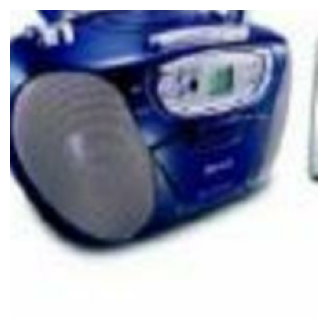

In [23]:
img_to_show = next(iter(train_loader))[0]
show_images(img_to_show)

### Patch Generation
Convert images into non-overlapping patches using tensor operations. Each patch becomes a token for the encoder.

torch.Size([49, 3, 32, 32])


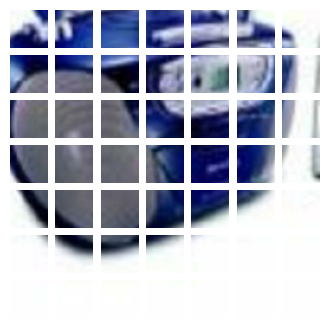

In [24]:
def patch_image(img):
    """
    Splits an image tensor into non-overlapping patches.

    Args:
        img (torch.Tensor): Input image tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Tensor of image patches with shape (num_patches, C, patch_size, patch_size).
    """
    return (
        img.unfold(1, patch_size, patch_size)  # Split height into patches
        .unfold(2, patch_size, patch_size)  # Split width into patches
        .permute((0, 3, 4, 1, 2))  # Rearrange dimensions for patches
        .flatten(3)  # Flatten the patch dimensions
        .permute((3, 0, 1, 2))  # Rearrange to (num_patches, C, patch_size, patch_size)
    )


patched_img = patch_image(img_to_show)
print(patched_img.shape)
show_images(patched_img)

### Calculate Masking Parameters
Determine the number of patches to mask based on the mask ratio (75% in this case).

In [25]:
tokens = patched_img.shape[0]
mask_ratio = 0.75
mask_count = int(tokens * mask_ratio)
print(f"{tokens} total tokens, {mask_count} masked patches")  # (49, 36)

49 total tokens, 36 masked patches


### Generate Random Mask
Create a random binary mask by selecting indices to mask, then visualize the masked image patches.

tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1])


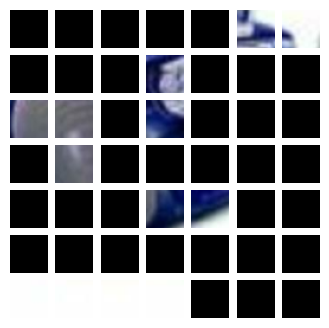

In [26]:
mask_idx = torch.randperm(tokens)[:mask_count]
mask = torch.zeros(tokens).long()
mask[mask_idx] = 1
print(mask)
show_images(patched_img, mask)

### Extract Visible Patches
Select only non-masked patches to serve as input to the encoder.

In [ ]:
input_tokens = patched_img[~mask.bool(), ...]
print(f"Tokens tensor shape: {input_tokens.shape}")
input_tokens = input_tokens.flatten(1)
input_tokens.shape  # torch.Size([13, 3072])

Tokens tensor shape: torch.Size([13, 3, 32, 32])


torch.Size([13, 3072])

## 4. Encoder Architecture

### Patch Embedding Module
Define a module that converts images into patch embeddings using convolution, with optional masking support.

In [29]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        """
        PatchEmbedding class to split an image into patches and embed them.

        Args:
            embed_dim (int): Dimension of the embedding.
            patch_size (int): Size of each patch (height and width).
            num_patches (int): Total number of patches.
            dropout (float): Dropout probability.
            in_channels (int): Number of input channels in the image.
        """
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,  # Ensures no overlap between patches
            ),
            nn.Flatten(
                2
            ),  # Flatten the patches while keeping batch and channel dimensions
        )

    def forward(self, x, mask=None):
        """
        Forward pass to create patches and optionally apply a mask.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
            mask (torch.Tensor, optional): Binary mask to exclude certain patches.

        Returns:
            torch.Tensor: Embedded patches of shape (batch_size, num_patches, embed_dim).
        """
        # Create patches and permute dimensions to (batch_size, num_patches, embed_dim)
        x = self.patcher(x).permute(0, 2, 1)

        # Apply mask if provided
        if mask is not None:
            x = x[:, ~mask.bool(), :]

        return x

### Test Patch Embedding
Instantiate the patch embedder and apply it to a test image with masking.

In [ ]:
# Get a single image from the training loader
batch_to_test = next(iter(train_loader))[:1]
print(f"Batch to test shape: {batch_to_test.shape}")

# Define image and patch shapes
image_shape = batch_to_test.shape[2:]
patch_shape = (32, 32)

# Define embedding dimensions and calculate the number of patches
embed_dim = 768
num_patches = (image_shape[0] // patch_shape[0]) * (image_shape[1] // patch_shape[1])

# Initialize the PatchEmbedding module
patch_embedder = PatchEmbedding(
    patch_size=patch_shape,
    embed_dim=embed_dim,
    in_channels=3,
    dropout=0.1,
    num_patches=num_patches,
)

# Generate input tokens using the patch embedder and mask
input_tokens = patch_embedder(batch_to_test, mask=mask)

# Print the shape of the input tokens and the total number of patches
print(f"Input tokens shape: {input_tokens.shape}, num_patches: {num_patches}")

Batch to test shape: torch.Size([1, 3, 224, 224])
Input tokens shape: torch.Size([1, 13, 768]), num_patches: 49


### Positional Embeddings
Add positional information to patch embeddings to preserve spatial relationships between patches.

In [46]:
# Initialize position embeddings with zeros (no gradient updates required)
pos_embed = nn.Parameter(torch.zeros(num_patches, embed_dim), requires_grad=False)
print(f"Position embedding shape: {pos_embed.shape}")  # torch.Size([49, 768])

# Select position embeddings corresponding to non-masked patches
non_masked_pos_embed = pos_embed[~mask.bool(), ...]
print(
    f"Non-masked position embedding shape: {non_masked_pos_embed.shape}"
)  # torch.Size([13, 768])

# Add position embeddings to the input tokens
pos_input_tokens = input_tokens + non_masked_pos_embed
print(
    f"Positioned input tokens shape: {pos_input_tokens.shape}"
)  # torch.Size([13, 768])

Position embedding shape: torch.Size([49, 768])
Non-masked position embedding shape: torch.Size([13, 768])
Positioned input tokens shape: torch.Size([1, 13, 768])


### CLS Token
Prepend a learnable class token to the sequence, commonly used in Vision Transformers for aggregating information.

In [47]:
# Initialize the class token as a learnable parameter
cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

# Expand the class token to match the batch size
cls_token = cls_token.expand(input_tokens.shape[0], -1, -1)

# Print the shape of the expanded class token
print(f"Token shape: {cls_token.shape}")  # Expected shape: (batch_size, 1, embed_dim)

# Concatenate the class token with the positional input tokens
tokens = torch.cat([cls_token, pos_input_tokens], dim=1)

# Print the shape of the resulting tokens
print(
    f"Tokens shape: {tokens.shape}"
)  # Expected shape: (batch_size, num_patches + 1, embed_dim)

Token shape: torch.Size([1, 1, 768])
Tokens shape: torch.Size([1, 14, 768])


### Transformer Encoder Block
Import and instantiate a Vision Transformer block from the `timm` library to encode the visible patches.

In [48]:
from timm.models.vision_transformer import Block

# Initialize a Vision Transformer block with embedding dimension 768 and 12 attention heads
block = Block(dim=768, num_heads=12)

# Display the block configuration
block

Block(
  (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=False)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=768, out_features=768, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

### Encode Tokens
Pass the tokens through the encoder block to generate contextual encodings.

In [ ]:
encodings = block(tokens)
print(f"Encodings shape {encodings.shape}")  # torch.Size([14, 768])

Encodings shape torch.Size([1, 14, 768])


## 5. Decoder Architecture

### Decoder Embedding Projection
Project encoder outputs to decoder embedding dimension using a linear layer.

In [ ]:
decoder_embed_dim = 512
decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
print(decoder_embed)

decoder_tokens = decoder_embed(encodings)
print(f"Decoder tokens shape: {decoder_tokens.shape}")

Linear(in_features=768, out_features=512, bias=True)
Decoder tokens shape: torch.Size([1, 14, 512])


### Learnable Mask Tokens
Create learnable mask tokens to represent the masked patches in the decoder. These are inserted at masked positions.

In [ ]:
mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
torch.nn.init.normal_(mask_token, std=0.02)
print(f"Mask token shape: {mask_token.shape}")  # torch.Size([1, 512])

tokens = torch.zeros((1, num_patches, decoder_embed_dim))
tokens[:, ~mask.bool(), :] = decoder_tokens[:, 1:, :]
tokens[:, mask.bool(), :] = torch.cat(
    [mask_token] * (num_patches - (~mask.bool()).sum()), dim=1
)
print(f"Tokens shape: {tokens.shape}")  # torch.Size([1, 49, 512])

Mask token shape: torch.Size([1, 1, 512])
Tokens shape: torch.Size([1, 49, 512])


### Decoder Positional Embeddings
Add positional embeddings to all decoder tokens (both visible and masked) to maintain spatial information. Note that the token's shape does not change

In [ ]:
decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim))
print(decoder_pos_embed.shape)  # torch.Size([1, 49, 512])

tokens = tokens + decoder_pos_embed
print(f"Tokens shape: {tokens.shape}")  # torch.Size([1, 49, 512])

torch.Size([1, 49, 512])
Tokens shape: torch.Size([1, 49, 512])


### Decoder Transformer Block
Concatenate CLS token with decoder tokens and create a transformer block for decoding.

In [ ]:
tokens = torch.cat([decoder_tokens[:, :1, :], tokens], dim=1)
print(f"Tokens shape with cls token: {tokens.shape}")  # torch.Size([50, 512])

decoder_num_heads = 8
decoder_block = Block(
    decoder_embed_dim, decoder_num_heads, 4, qkv_bias=True, norm_layer=nn.LayerNorm
)
decoder_block

Tokens shape with cls token: torch.Size([1, 50, 512])


Block(
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=512, out_features=1536, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (proj): Linear(in_features=512, out_features=512, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ls1): Identity()
  (drop_path1): Identity()
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=512, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=2048, out_features=512, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (ls2): Identity()
  (drop_path2): Identity()
)

### Decoder Prediction Head
Define normalization and linear projection layers to map decoder outputs back to pixel space.

In [60]:
decoder_norm = nn.LayerNorm(decoder_embed_dim)
decoder_pred = nn.Linear(
    decoder_embed_dim, patch_size**2 * 3, bias=True
)  # decoder to patch
decoder_pred
# Linear(in_features=512, out_features=3072, bias=True)


Linear(in_features=512, out_features=3072, bias=True)

### Generate Predictions
Pass tokens through decoder block, normalize, and project to get pixel-level predictions for all patches.

In [61]:
out_tokens = decoder_block(tokens).squeeze(0)
out = decoder_norm(out_tokens.unsqueeze(0)).squeeze(0)
# predictor projection
out = decoder_pred(out)
out.shape  # torch.Size([50, 3072])

final_img_predictions = out[1:, :]  # remove mask tokens
final_img_predictions.shape  # torch.Size([49, 3072])

torch.Size([49, 3072])

## 6. Loss Calculation

### Prepare Ground Truth
Extract and normalize the original patches to serve as ground truth for reconstruction loss.

In [62]:
print(image_to_test.shape)
inputs = patch_image(image_to_test.squeeze(0)).flatten(1)
print(inputs.shape, final_img_predictions.shape, mask.shape)
# (torch.Size([49, 3072]), torch.Size([49, 3072]), torch.Size([49]))


mean = inputs.mean(dim=-1, keepdim=True)
var = inputs.var(dim=-1, keepdim=True)
inputs = (inputs - mean) / (var + 1.0e-6) ** 0.5
inputs.shape  # torch.Size([49, 3072])

torch.Size([3, 224, 224])
torch.Size([49, 3072]) torch.Size([49, 3072]) torch.Size([49])


torch.Size([49, 3072])

### Compute Reconstruction Loss
Calculate mean squared error between predictions and ground truth, but only for masked patches. This is the core MAE training objective.

In [63]:
token_level_loss = ((final_img_predictions - inputs) ** 2).mean(dim=-1)
print(token_level_loss)

loss = (token_level_loss * mask).sum() / mask.sum()
print(loss)

tensor([1.1896, 1.2140, 1.3198, 1.3786, 1.3608, 1.3403, 1.3239, 1.3649, 1.3523,
        1.3497, 1.3289, 1.3656, 1.3382, 1.3398, 1.3100, 1.3339, 1.3223, 1.3242,
        1.3240, 1.2908, 1.3040, 1.3392, 1.3354, 1.3567, 1.3265, 1.3215, 1.3083,
        1.3537, 1.2997, 1.3251, 1.3197, 1.3211, 1.3183, 1.3409, 1.3216, 1.2569,
        1.3167, 1.3244, 1.3130, 1.3047, 1.3029, 1.3325, 0.3324, 0.3324, 0.9723,
        1.3471, 1.2996, 1.3153, 1.1883], grad_fn=<MeanBackward1>)
tensor(1.3162, grad_fn=<DivBackward0>)
